In [ ]:
cd ..

In [2]:
import tqdm
import torch
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from src.data import load_M51
from src.sampling.uv_sampling import random_sampling

# Operator

All the stuff you need for the operator can be found below:

In [4]:
import numpy as np
from scipy.special import iv, jv

def calculate_kaiser_bessel_coef(k, i, Jd=(6,6)):
    """Calculate the Kaiser-Bessel kernel coefficients for a 2d grid for the neighbouring pixels. 

    Args:
        k (float,float): location of the point to be interpolated
        i (int): extra index parameter
        Jd (tuple, optional): Amount of neighbouring pixels to be used in each direction. Defaults to (6,6).

    Returns:
        indices (list): list of indices of all the calculated coefficients
        values (list): list of the calculated coefficients
    """

    k = k.reshape(-1,1)
    J = Jd[0]//2
    a = np.array(np.meshgrid(range(-J, J), range(-J, J))).reshape(2, -1)
    a += (k % 1 >0.5) # corrects to the closest 6 pixels
    indices = (k.astype(int) + a)

    J = Jd[0]

    beta = 2.34*J
    norm = J 

    # for 2d do the interpolation 2 times, once in each direction
    u =  k.reshape(2,1) - indices
    values1 = iv(0, beta*np.sqrt(1 +0j - (2*u[0]/Jd[0])**2)).real / J 
    values2 = iv(0, beta*np.sqrt(1 +0j - (2*u[1]/Jd[0])**2)).real / J 
    values = values1 * values2
    
    indices = np.vstack((
            np.zeros(indices.shape[1]), 
            np.repeat(i, indices.shape[1]), indices[0], indices[1])
            ).astype(int)

    return indices.T, values


class NUFFT2D_Torch():
    """NUFFT implementation using a Kaiser-Bessel kernel for interpolation. 
    Implemented with TF operations. Only able to do the FFT on the last 2 axes 
    of the tensors provided. Slower than using the numpy_function on the np 
    based operations.
    """
    def __init__(self):
        pass
        
    def plan(self, uv, Nd, Kd, Jd, batch_size):
        # saving some values
        self.Nd = Nd
        self.Kd = Kd
        self.Jd = Jd
        self.batch_size = batch_size
        self.n_measurements = len(uv)
        
        self.K_norm = max(Kd[0], Kd[1])
        gridsize = 2*np.pi / self.K_norm
        k = (uv + np.pi) / gridsize
        
        # calculating coefficients for interpolation
        indices = []
        values =  []
        for i in tqdm.tqdm(range(len(uv))):
            ind, vals = calculate_kaiser_bessel_coef(k[i], i, Jd)
            indices.append(ind)
            values.append(vals.real)

        values = np.array(values).reshape(-1)
        indices = np.array(indices).reshape(-1, 4)

        self.indices = indices
        # check if indices are within bounds, otherwise suppress them and raise warning
        if np.any(indices[:,2:] < 0) or np.any(indices[:,2] >= Kd[0]) or np.any(indices[:,3] >= Kd[1]):
            sel_out_bounds = np.any([np.any(indices[:,2:] < 0, axis=1), indices[:,2] >= Kd[0], indices[:,3] >= Kd[1]], axis=0)
            print(f"some values lie out of the interpolation array, these are not used, check baselines")
            indices[sel_out_bounds] = 0
            values[sel_out_bounds] = 0
        
        # repeating the values and indices to match the batch_size 
        batch_indices = np.tile(indices[:,-2:], [batch_size, 1])
        batch_indicators = np.repeat(np.arange(batch_size), (len(values)))
        batch_indices = np.hstack((batch_indicators[:,None], batch_indices))
        
        self.flat_batch_indices = torch.LongTensor(np.ravel_multi_index(batch_indices.T, (batch_size, Kd[0], Kd[1])))
        
        self.batch_indices = list(torch.LongTensor(batch_indices).T)
        self.batch_values = np.tile(values, [batch_size,1]).astype(np.float32).reshape(self.batch_size, self.n_measurements, self.Jd[0]*self.Jd[1])


        # determine scaling based on iFT of the KB kernel
        J = Jd[0] 
        beta = 2.34*J
        s_kb = lambda x: np.sinc(np.sqrt((np.pi *x *J)**2 - (2.34*J)**2 +0j)/np.pi)

        xx_1 = (np.arange(Kd[0])/Kd[0] -.5)[(Kd[0]-Nd[0])//2:(Kd[0]-Nd[0])//2 + Nd[0]]
        xx_2 = (np.arange(Kd[1])/Kd[1] -.5)[(Kd[1]-Nd[1])//2:(Kd[1]-Nd[1])//2 + Nd[1]]
        
        sa_1 = s_kb(xx_1).real
        sa_2 = s_kb(xx_2).real
        
        self.scaling = (sa_1.reshape(-1,1) * sa_2.reshape(1,-1)).reshape(1, Nd[0], Nd[1])
        self.scaling = torch.tensor(self.scaling, dtype=torch.complex64)
        self.forward = self.dir_op
        self.adjoint = self.adj_op


    def dir_op(self, xx):
        xx = torch.tensor(xx, dtype=torch.complex64)
        xx = xx/self.scaling
        xx = self._pad(xx)
        kk = self._xx2kk(xx) / self.K_norm
        k = self._kk2k(kk)
        return k


    def adj_op(self, k):
        # split real and imaginary parts because complex operations not defined for sparseTensors

        kk = self._k2kk(k)
        xx = self._kk2xx(kk) * self.K_norm
        xx = self._unpad(xx)
        xx = xx / self.scaling

        return xx
    
    def _kk2k(self, kk):
        """interpolates of the grid to non uniform measurements"""
        
        print(kk.shape)
        
        return (kk[self.batch_indices].reshape(self.batch_size, self.n_measurements, self.Jd[0]*self.Jd[1]) * self.batch_values).sum(axis=-1)
    
    def _k2kk(self, k):
        """convolutes measurements to oversampled fft grid"""
        interp = (k.reshape(self.batch_size, self.n_measurements, 1) * self.batch_values).reshape(-1)
        
        kk_flat = torch.zeros(self.batch_size * self.Kd[0] * self.Kd[1], dtype=torch.complex64)
        kk_flat.scatter_add_(0, self.flat_batch_indices, interp )

        return kk_flat.reshape(self.batch_size, self.Kd[0], self.Kd[1])
    
    @staticmethod
    def _kk2xx(kk):
        """from 2d fourier space to 2d image space"""
        return torch.fft.ifftshift(torch.fft.ifft2(torch.fft.ifftshift(kk, dim=(-2,-1))), dim=(-2,-1)) 

    @staticmethod
    def _xx2kk(xx):
        """from 2d fourier space to 2d image space"""
        return torch.fft.fftshift(torch.fft.fft2(torch.fft.fftshift(xx, dim=(-2,-1))), dim=(-2,-1))
    
    def _pad(self, x):
        """pads x to go from Nd to Kd"""
        return torch.nn.functional.pad(x, (
            (self.Kd[1]-self.Nd[1])//2, (self.Kd[1]-self.Nd[1])//2,
            (self.Kd[0]-self.Nd[0])//2, (self.Kd[0]-self.Nd[0])//2,
            0, 0,
            )
        )
    
    def _unpad(self, x):
        """unpads x to go from  Kd to Nd"""
        return x[
            :,
            (self.Kd[0]-self.Nd[0])//2: (self.Kd[0]-self.Nd[0])//2 +self.Nd[0],
            (self.Kd[1]-self.Nd[1])//2: (self.Kd[1]-self.Nd[1])//2 +self.Nd[1]
            ] 


# Testing

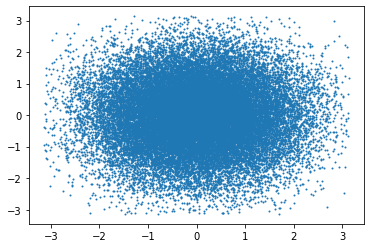

In [5]:
im = load_M51()
uv = random_sampling(im.shape[0]**2//2) # uv coordinates between [-pi, pi]

plt.scatter(uv[:,0], uv[:,1], s=1)

In [12]:
# set up operator
m_op_torch = NUFFT2D_Torch()

Nd = (256,256)
Kd = (512,512) # up-sampling of 2x is typical (and also hardcoded in the operator..)
Jd = (6,6) # 6x6 typical size for gridding kernel
batch_size = 2

m_op_torch.plan(uv, Nd, Kd, Jd, batch_size)

100%|██████████| 32768/32768 [00:05<00:00, 6081.75it/s]


some values lie out of the interpolation array, these are not used, check baselines


In [13]:
x = np.vstack((im[np.newaxis,:], im[np.newaxis,:]))
x_torch = torch.tensor(x, dtype=torch.complex64)

In [14]:
%%time
y_torch = m_op_torch.dir_op(x_torch)

torch.Size([2, 512, 512])
CPU times: user 52.8 ms, sys: 2.99 ms, total: 55.8 ms
Wall time: 55.8 ms


/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/ipykernel_launcher.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [15]:
%%time
x_dirty_torch = m_op_torch.adj_op(y_torch)

CPU times: user 22.6 ms, sys: 3.03 ms, total: 25.6 ms
Wall time: 28.5 ms


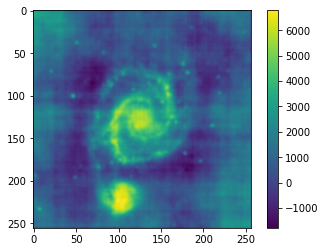

In [16]:
plt.imshow(x_dirty_torch[0].real)
plt.colorbar()

# Compare to TF operator

In [17]:
from src.operators.NUFFT2D_TF import NUFFT2D_TF

In [18]:
m_op_tf = NUFFT2D_TF()
m_op_tf.plan(uv, Nd, Kd, Jd, batch_size)

100%|██████████| 32768/32768 [00:05<00:00, 6119.89it/s]


some values lie out of the interpolation array, these are not used, check baselines


In [19]:
%%time
y_tf = m_op_tf.dir_op(x)

CPU times: user 491 ms, sys: 117 ms, total: 608 ms
Wall time: 615 ms


In [20]:
%%time
x_dirty_tf = m_op_tf.adj_op(y_tf)

CPU times: user 439 ms, sys: 295 ms, total: 734 ms
Wall time: 740 ms


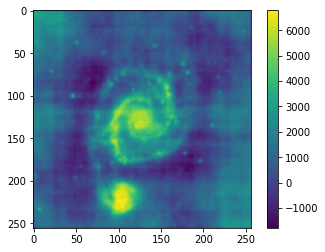

In [21]:
plt.imshow(x_dirty_tf[0].numpy().real)
plt.colorbar()

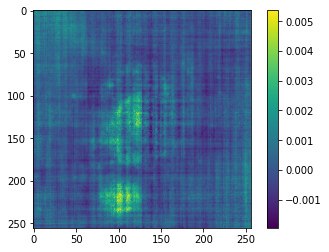

In [22]:
plt.imshow(x_dirty_torch[0].real - x_dirty_tf[0].numpy().real)
plt.colorbar()

In [23]:
np.linalg.norm(y_torch[0].real- y_tf[0].numpy().real)

0.13923983

In [24]:
np.linalg.norm(x_dirty_torch[0].real- x_dirty_tf[0].numpy().real)

0.19467299

Operands show minor differences, this is due to how the scatter operation is implemented in the backend. Is no problem if you use one of them consistently.

# Working with non-square images

This functionality is a WIP and outcomes have not been tested. Works probably best if the image is close to being square.

In [30]:
im = im[:,:128]

Nd=(256,128)
Kd=(512,256)
Jd=(6,6)
batch_size=2

m_op_torch.plan(uv, Nd, Kd, Jd, batch_size)

100%|██████████| 32768/32768 [00:05<00:00, 6090.11it/s]


some values lie out of the interpolation array, these are not used, check baselines


In [31]:
x = np.vstack((im[np.newaxis,:], im[np.newaxis,:]))
x_torch = torch.tensor(x, dtype=torch.complex64)

In [32]:
%%time
y_torch = m_op_torch.dir_op(x_torch)

torch.Size([2, 512, 256])
CPU times: user 40 ms, sys: 0 ns, total: 40 ms
Wall time: 40.1 ms


/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/ipykernel_launcher.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [33]:
%%time
x_dirty_torch = m_op_torch.adj_op(y_torch)

CPU times: user 17.4 ms, sys: 927 µs, total: 18.4 ms
Wall time: 18.4 ms


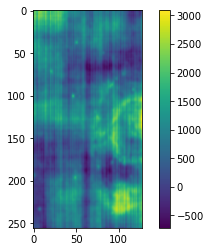

In [34]:
plt.imshow(x_dirty_torch[0].real)
plt.colorbar()